# Figure S1 (Supplementary material)
### Temperature-Salinity-Pb method illustration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
import xarray as xr
from constants import imin, imax, jmin, jmax, isize, jsize, \
                      rimwidthN, rimwidthS, rimwidthW, rimwidthE, \
                      bdy_NCB, bdy_WCB, bdy_LS, bdy_HB, \
                      land_color, light_land, land_edge, light_gray,\
                      path_figure

%matplotlib inline

#### Parameters

In [2]:
# Colors
color_sBB  = '#cc0e1d'
color_sGR  = '#ffb7aa'

#### Load files

In [4]:
# Pb model configuration ANHA12 mask
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mesh.nav_lon.values
mesh_lat     = mesh.nav_lat.values
mesh_bathy   = mesh.tmask.values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
depths       = mesh.nav_lev.values

In [5]:
# temperature and salinity at start of time series:
df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
temp = df_gridT['votemper'].values[0,:,:,:]
sal  = df_gridT['vosaline'].values[0,:,:,:]

#### Functions

In [6]:
def load_climatology(year, month):        
    # load temperature and salinity climatology from the ANHA12 gridT file:
    df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/new_averages/gridT_{year}_{month:02}.nc')
    
    bdy_temp = df_gridT['votemper'].values[:,:,:]
    bdy_sal  = df_gridT['vosaline'].values[:,:,:]
    
    return bdy_temp, bdy_sal

#### Calculations

In [9]:
model_lons = np.tile(mesh_lon, (50,1,1))
model_lats = np.tile(mesh_lat, (50,1,1))
model_depths = np.moveaxis(np.tile(mesh.nav_lev.values, (2400, 1632,1)),[2],[0])

In [10]:
year=2015
month=8

T, S = load_climatology(year, month)

# convert units from potential to conservative temperature and practical to absolute salinity
S_abs   = gsw.conversions.SA_from_SP(S, model_depths, model_lons, model_lats) # absolute salinity
T_cons  = gsw.conversions.CT_from_pt(S_abs, T) # conservative temperature

# Subset to the boundary locations
LS_T  = T_cons[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
LS_S  = S_abs[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
nCB_T = T_cons[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]]
nCB_S = S_abs[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]]
wCB_T = T_cons[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
wCB_S = S_abs[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
HB_T  = T_cons[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
HB_S  = S_abs[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]]

Boundary conditions:

In [11]:
# load dissolved Pb concentrations in the model boundary conditions
BC      = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/bdy-reference/Pb_OBC_y2015m08.nc')
dPb_LS  = BC.dPb_S.values.reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2], order='C')
dPb_wCB = np.flip(BC.dPb_N.values.reshape(50,rimwidthN,bdy_WCB[3]-bdy_WCB[2], order='C'), axis=1)
dPb_nCB = np.flip(BC.dPb_E.values.reshape(50,rimwidthE,bdy_NCB[1]-bdy_NCB[0], order='F'), axis=2)
dPb_HB  = BC.dPb_W.values.reshape(50,rimwidthW,bdy_HB[1]-bdy_HB[0], order='F')
BC.close()

#### Figures

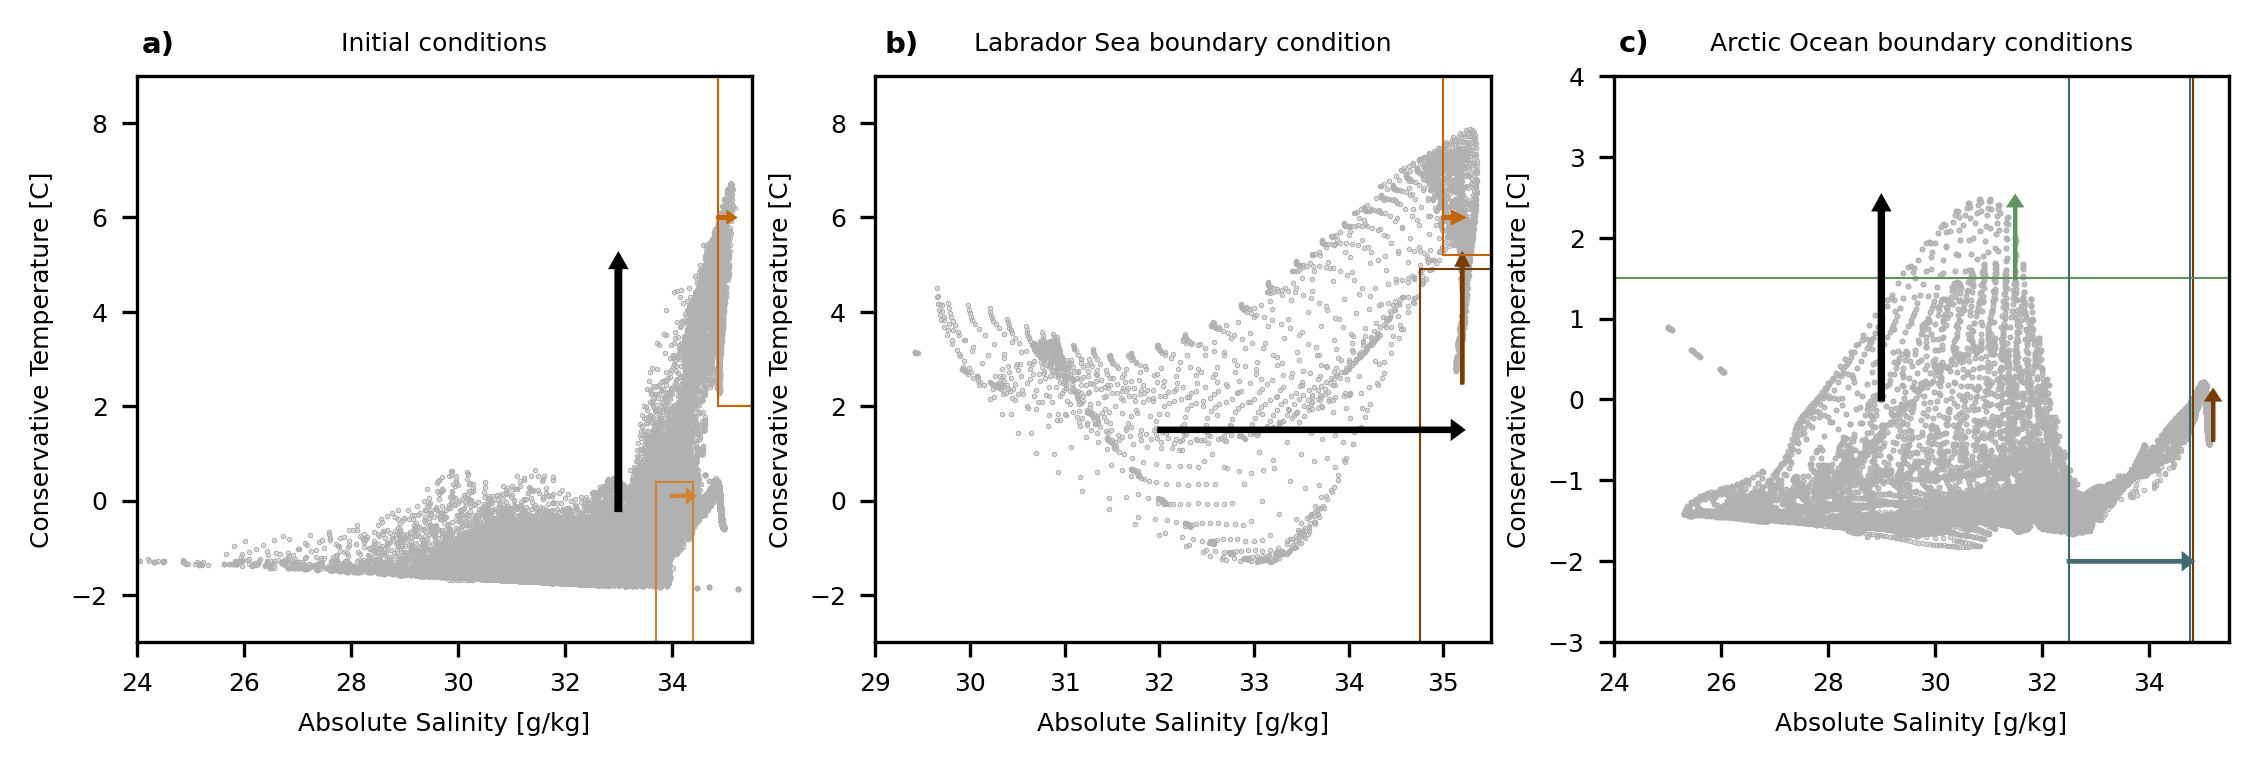

In [15]:
fig, ax = plt.subplots(1,3, figsize=(9,2.5), dpi=300)
kwags = {'length_includes_head':True}
layer = 5

for n,axis in enumerate(ax.ravel()):
    axis.tick_params(axis='both', labelsize=6)
    axis.set_ylabel('Conservative Temperature [C]', fontsize=6)
    axis.set_xlabel('Absolute Salinity [g/kg]', fontsize=6)
    
ax[0].set_title('Initial conditions', fontsize=6)
ax[1].set_title('Labrador Sea boundary condition', fontsize=6)
ax[2].set_title('Arctic Ocean boundary conditions', fontsize=6)

ax[0].text(24.1, 9.5, 'a)', fontsize=7, weight='bold');
ax[1].text(29.1, 9.5, 'b)', fontsize=7, weight='bold');
ax[2].text(24.1, 4.3, 'c)', fontsize=7, weight='bold');

#----- Initial conditions: -----------------------------------------------------------
ax[0].scatter(sal[:,imin:imax,jmin:jmax][:,::10,::10], temp[:,imin:imax,jmin:jmax][:,::10,::10], \
                c=light_gray, s=0.1, zorder=1, alpha=1)
LSW_color = '#c56400'
WGC_color = '#d08332'
# water masses:
ax[0].plot([33.7, 34.4],[0.4,0.4], '-', color=WGC_color, linewidth=0.5)
ax[0].plot([33.7, 33.7],[-3,0.4], '-', color=WGC_color, linewidth=0.5)
ax[0].plot([34.4, 34.4],[-3,0.4], '-', color=WGC_color, linewidth=0.5)
ax[0].plot([34.86, 36],[2,2], '-', color=LSW_color, linewidth=0.5)
ax[0].plot([34.86, 34.86],[2,9], '-', color=LSW_color, linewidth=0.5)
# interpolations:
ax[0].arrow(33., -0.2, 0, 5.4, head_width=0.25, head_length=0.25, width=0.07, fc='k', ec='k', **kwags) # Arctic --> Atlantic
ax[0].arrow(34.86, 6, 0.3, 0, head_width=0.15, head_length=0.1, fc=LSW_color, ec=LSW_color, **kwags) # enhance Atlantic
ax[0].arrow(34, 0.1, 0.4, 0, head_width=0.2, head_length=0.1, fc=WGC_color, ec=WGC_color, **kwags) # Atlantic WGC
ax[0].set_ylim(-3,9)
ax[0].set_xlim(24,35.5)

#----- Labrador Sea: -----------------------------------------------------------
full_T = [-3,9]
ax[1].scatter(LS_S[:,layer,:] , LS_T[:,layer,:] , c=light_gray, s=0.1, zorder=1, alpha=1)
# water masses:
AW_color = '#c56400'
DW_color = '#763c00'
ax[1].plot([35, 35],[5.2, 9], '-', color=AW_color, linewidth=0.5)
ax[1].plot([35, 36],[5.2, 5.2], '-', color=AW_color, linewidth=0.5)
ax[1].plot([34.75, 34.75],[-3, 4.9], '-', color=DW_color, linewidth=0.5)
ax[1].plot([34.75, 36],[4.9,4.9], '-', color=DW_color, linewidth=0.5)
# interpolations:
ax[1].arrow(32, 1.5, 3.2, 0, head_width=0.3, head_length=0.1, width=0.05, fc='k', ec='k', zorder=3, **kwags)
ax[1].arrow(35.2, 2.5, 0, 2.7, head_width=0.1, head_length=0.2, fc=DW_color, ec=DW_color, **kwags)
ax[1].arrow(35, 6, 0.2, 0, head_width=0.2, head_length=0.1, fc=AW_color, ec=AW_color, **kwags)
ax[1].set_ylim(-3,9)
ax[1].set_xlim(29,35.5) 

#----- Northern Canada Basin: -----------------------------------------------------------
ax[2].scatter(nCB_S[:,:,layer], nCB_T[:,:,layer], c=light_gray, s=0.1, zorder=1, alpha=1)
# water masses:
ACW_color  = '#639360'
wBSW_color = '#406a6e'
deep_color = '#763c00'
ax[2].plot([34.82, 34.82],full_T, '-', color=deep_color, linewidth=0.5)
ax[2].plot([24, 36],[1.5,1.5], '-', color=ACW_color, linewidth=0.5)
ax[2].plot([32.5, 32.5],full_T, '-', color=wBSW_color, linewidth=0.5)
ax[2].plot([34.77, 34.77],full_T, '-', color=wBSW_color, linewidth=0.5)
# interpolations:
ax[2].arrow(29, 0, 0, 2.5, head_width=0.25, head_length=0.15, fc='k', ec='k', zorder=3, width=0.06, **kwags) # PML --> ACW
ax[2].arrow(31.5, 1.5, 0, 1, head_width=0.2, head_length=0.1, fc=ACW_color, ec=ACW_color, **kwags) # enhance ACW
ax[2].arrow(32.5, -2, 2.3, 0, head_width=0.15, head_length=0.15, fc=wBSW_color, ec=wBSW_color, zorder=3, **kwags) # wBSW --> AL
ax[2].arrow(35.2, -0.5, 0, 0.6, head_width=0.2, head_length=0.1, fc=deep_color, ec=deep_color, **kwags) # AL --> CBDW
#----- Western Canada Basin: ----
ax[2].scatter(wCB_S[:,layer,:], wCB_T[:,layer,:], c=light_gray, s=0.2, zorder=1, alpha=1)
ax[2].set_ylim(-3,4)
ax[2].set_xlim(24,35.5) 

fig.savefig(f'{path_figure}S1-endmembers.jpg', dpi=300, bbox_inches='tight')